In [1]:
import torch
from torch.utils.data import DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
#from google.colab import drive
from transformers import BertForSequenceClassification
from peft import LoraConfig, TaskType
from peft import get_peft_model
from tqdm import tqdm
import pandas as pd

In [2]:
NAICS_2022 = pd.read_csv('NAICS_2022.csv')

NAICS_2022['INDUSTRY_GROUP'] = NAICS_2022['Code']//100

NAICS_2022 = NAICS_2022.dropna(subset=['EXAMPLE']).reset_index(drop=True)

# We define a function called extract_examples whose input is a text and output is a list of words
# which are extracted from that text. After doing some preprocess on the text, we split the text by semi-colon.

def extract_examples(text):
    # Lowercase the text
    text = text.lower()
    text = text.replace('for example, ','')
    
    # Remove punctuation marks
    #text = ''.join(char for char in text if char not in punctuation_without_semicolon)
    
    # Remove stopwords
    words = text.split()
    #words = [word for word in words if word not in stopwords]
    
    for i in range(len(words)):
        if ";" in words[i]:
            word = words[i].replace(";", "")
            stemmed_word = word + ";"
            words[i] = stemmed_word        
        #else:
         #   words[i] = stemmer.stem(words[i])
    
    
    
    # Stem the words
    #words = [stemmer.stem(word) for word in words]
    
    # Join the words back into a string
    text = ' '.join(words)
    
    list_words = text.rstrip('; ').split(';')
    # Use Yake to extract keywords from the preprocessed text
    #keywords = custom_kw_extractor.extract_keywords(text)
    #keywords = [t[0] for t in keywords]
    #if len(keywords) != 1:
       # keywords = [t for t in keywords if len(t.split()) > 1]
        
    #keywords = [t[0] for t in keywords if len(t[0].split()) > 1]
    
    return list_words


# Here we apply the extract_examples function on the EXAMPLE column of the dataset. 
# EXAMPLE column comprises of many examples which are separated by semi-colon.

NAICS_2022['EXAMPLE_SPLIT'] = NAICS_2022['EXAMPLE'].apply(lambda x: extract_examples(x))


# Labeling the INDUSTRY_GROUP column: we have 312 classes in the industry group level (first 4 digits of NAICS code)
# and we label them from 0 to 311.

INPUT_DF = NAICS_2022.copy()


INPUT_DF_EXPLODE = INPUT_DF.explode('EXAMPLE_SPLIT').reset_index(drop = True)

value_counts = INPUT_DF_EXPLODE['Code'].value_counts()
# Get the values that occur more than once
values_to_keep = value_counts[value_counts > 1].index

# Filter the DataFrame to keep only rows where the value in 'a' occurs more than once
INPUT_DF_EXPLODE = INPUT_DF_EXPLODE[INPUT_DF_EXPLODE['Code'].isin(values_to_keep)].reset_index(drop = True)

mapping_IG = {sec:idx for idx, sec in enumerate(list(INPUT_DF_EXPLODE.INDUSTRY_GROUP.unique()))}
INPUT_DF_EXPLODE['industry_group_label'] = INPUT_DF_EXPLODE['INDUSTRY_GROUP'].map(mapping_IG)

mapping_NAICS = {sec:idx for idx, sec in enumerate(list(INPUT_DF_EXPLODE.Code.unique()))}
INPUT_DF_EXPLODE['naics_label'] = INPUT_DF_EXPLODE['Code'].map(mapping_NAICS)

mapping_IG_reverse = {v:k for k, v in mapping_IG.items()}
mapping_NAICS_reverse = {v:k for k, v in mapping_NAICS.items()}

INPUT_DF_EXPLODE_SELECT = INPUT_DF_EXPLODE[['Class definition','EXAMPLE_SPLIT','industry_group_label','naics_label']]



In [3]:
NAICS_2022

,Level,Hierarchical structure,Code,Parent,Class title,Superscript,Class definition,EXAMPLE,INDUSTRY_GROUP,EXAMPLE_SPLIT
0,5,Canadian industry,111110,11111,Soybean farming,NaN,This Canadian industry comprises establishment...,"soybean farming, field and seed production; s...",1111,"[soybean farming, field and seed production, ..."
1,5,Canadian industry,111120,11112,Oilseed (except soybean) farming,US,This Canadian industry comprises establishment...,canola (rapeseed) farming; linseed (flaxseed)...,1111,"[canola (rapeseed) farming, linseed (flaxseed..."
2,5,Canadian industry,111130,11113,Dry pea and bean farming,US,This Canadian industry comprises establishment...,bean or pea farming (field crop); dry bean fa...,1111,"[bean or pea farming (field crop), dry bean f..."
3,5,Canadian industry,111140,11114,Wheat farming,NaN,This Canadian industry comprises establishment...,"wheat (i.e., spring, winter and durum) growin...",1111,"[wheat (i.e., spring, winter and durum) growin..."
4,5,Canadian industry,111150,11115,Corn farming,US,This Canadian industry comprises establishment...,"corn (except sweet corn) farming, field and s...",1111,"[corn (except sweet corn) farming, field and s..."
...,...,...,...,...,...,...,...,...,...,...
918,5,Canadian industry,913910,91391,"Other local, municipal and regional public adm...",CAN,This Canadian industry comprises establishment...,"adult education program, local; amusement tax...",9139,"[adult education program, local, amusement ta..."
919,5,Canadian industry,914111,91411,First Nations public administration,CAN,This Canadian industry comprises establishment...,First Nations Band Council; First Nations Sel...,9141,"[first nations band council, first nations se..."
920,5,Canadian industry,914112,91411,MÃ©tis public administration,CAN,This Canadian industry comprises establishment...,Métis Self-Government;,9141,[métis self-government]
921,5,Canadian industry,914113,91411,Inuit public administration,CAN,This Canadian industry comprises establishment...,Inuit Self-Government;,9141,[inuit self-government]


In [4]:
if torch.cuda.is_available():
    print("GPU is available!")
else:
    print("GPU is not available. Using CPU.")

GPU is available!


In [5]:
len(INPUT_DF_EXPLODE_SELECT)

19138

In [6]:
X_train, X_valid, y_train, y_valid = train_test_split(
    INPUT_DF_EXPLODE_SELECT['EXAMPLE_SPLIT'],
    INPUT_DF_EXPLODE_SELECT['industry_group_label'],
    test_size=0.1,
    random_state=42,
    stratify=INPUT_DF_EXPLODE_SELECT['industry_group_label']
)

In [7]:
roberta_checkpoint = "roberta-large"
roberta_checkpoint = "roberta-base"
tokenizer = AutoTokenizer.from_pretrained(roberta_checkpoint, add_prefix_space=True)
train_encodings = tokenizer(list(X_train), truncation=True, padding=True, return_tensors='pt')
valid_encodings = tokenizer(list(X_valid), truncation=True, padding=True, return_tensors='pt')

In [8]:
# Convert labels to tensors
train_labels = torch.tensor(list(y_train))
valid_labels = torch.tensor(list(y_valid))


In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = 'cpu'
train_encodings = {key: val.to(device) for key, val in train_encodings.items()}
valid_encodings = {key: val.to(device) for key, val in valid_encodings.items()}
train_labels = train_labels.to(device)
valid_labels = valid_labels.to(device)

In [10]:
train_encodings

{'input_ids': tensor([[    0,  3055, 39156,  ...,     1,     1,     1],
         [    0,  3111,   108,  ...,     1,     1,     1],
         [    0,  1748, 12174,  ...,     1,     1,     1],
         ...,
         [    0, 13011, 19565,  ...,     1,     1,     1],
         [    0, 13030,   636,  ...,     1,     1,     1],
         [    0, 16661,    36,  ...,     1,     1,     1]], device='cuda:0'),
 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         ...,
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]], device='cuda:0')}

In [11]:
from torch.utils.data import TensorDataset, DataLoader

# Assuming train_encoding and train_labels are your input data
train_dataset = TensorDataset(train_encodings['input_ids'], 
                              #train_encodings['token_type_ids'], 
                              train_encodings['attention_mask'], 
                              train_labels)


In [12]:
# Set batch size according to your preference
batch_size = 16

# Create DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)


In [13]:
valid_dataset = TensorDataset(valid_encodings['input_ids'], 
                              #valid_encodings['token_type_ids'], 
                              valid_encodings['attention_mask'], 
                              valid_labels)

valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)

In [14]:
NUM_CLASS = len(list(set(list(y_train))))

In [15]:
from transformers import AutoModelForSequenceClassification 
model = AutoModelForSequenceClassification.from_pretrained(roberta_checkpoint, num_labels=NUM_CLASS)



lora_config = LoraConfig(
    task_type=TaskType.SEQ_CLS, r=8, lora_alpha=1, lora_dropout=0.1
)

model = get_peft_model(model, lora_config)

# Set up training parameters
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)
model.to(device)

# Count trainable parameters
num_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Number of trainable parameters: {num_trainable_params}")

# Count total parameters (including non-trainable)
num_total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {num_total_params}")

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Number of trainable parameters: 1131584
Total number of parameters: 126023296


In [17]:
1131584/126023296

0.00897916524893937

In [16]:
print(model)

PeftModelForSequenceClassification(
  (base_model): LoraModel(
    (model): RobertaForSequenceClassification(
      (roberta): RobertaModel(
        (embeddings): RobertaEmbeddings(
          (word_embeddings): Embedding(50265, 768, padding_idx=1)
          (position_embeddings): Embedding(514, 768, padding_idx=1)
          (token_type_embeddings): Embedding(1, 768)
          (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (encoder): RobertaEncoder(
          (layer): ModuleList(
            (0-11): 12 x RobertaLayer(
              (attention): RobertaAttention(
                (self): RobertaSelfAttention(
                  (query): Linear(
                    in_features=768, out_features=768, bias=True
                    (lora_dropout): ModuleDict(
                      (default): Dropout(p=0.1, inplace=False)
                    )
                    (lora_A): ModuleDict(
                      

In [26]:
torch.cuda.empty_cache()

In [27]:
import torch
import torch.nn as nn
from torch.nn.parallel import DataParallel


# Check if multiple GPUs are available
if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs!")
    model = DataParallel(model)

# Move the model to GPU(s)
model = model.cuda()

# Now you can use the model as usual


In [28]:
import torch

# Limit GPU memory growth
#torch.cuda.set_per_process_memory_fraction(0.8)  # Adjust the fraction as needed


In [29]:
#pip install nvidia-ml-py3

In [30]:
from transformers import  AdamW, get_linear_schedule_with_warmup
from sklearn.metrics import f1_score, balanced_accuracy_score
from tqdm import tqdm
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:512"
# Number of training epochs
NUM_EPOCHS = 10
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=len(train_dataloader)*NUM_EPOCHS)
criterion = torch.nn.CrossEntropyLoss()



# Lists to store training losses and F1 scores
train_losses = []
valid_losses = []
f1_scores = []
balanced_accuracies = []
# Training loop with tqdm




for epoch in range(NUM_EPOCHS):
    torch.cuda.empty_cache()
    model.train()
    total_train_loss = 0.0



    # Use tqdm to create a progress bar
    progress_bar = tqdm(train_dataloader, desc=f'Epoch {epoch + 1}/{NUM_EPOCHS}', leave=False)

    for batch in progress_bar:
        input_ids,  attention_mask, labels = batch

        optimizer.zero_grad()
        #print('1')

        outputs = model(input_ids,  attention_mask=attention_mask, labels=labels)
        loss = outputs.loss

        total_train_loss += loss.item()
        #os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:1024"

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)  # Gradient clipping to prevent exploding gradients
        #print('2')
        

        optimizer.step()
        scheduler.step()

        #print('3')

        # Update the tqdm progress bar with the current loss
        progress_bar.set_postfix({'Training Loss': loss.item()})

    average_train_loss = total_train_loss / len(train_dataloader)
    train_losses.append(average_train_loss)

    # Validation
    model.eval()
    total_valid_loss = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in valid_dataloader:
            input_ids, attention_mask, labels = batch

            outputs = model(input_ids,  attention_mask=attention_mask, labels=labels)
            loss = outputs.loss

            total_valid_loss += loss.item()

            logits = outputs.logits
            preds = torch.argmax(logits, dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())

    average_valid_loss = total_valid_loss / len(valid_dataloader)
    valid_losses.append(average_valid_loss)

    # Calculate F1 score
    f1 = f1_score(all_labels, all_preds, average='weighted')
    f1_scores.append(f1)
    balanced_acc = balanced_accuracy_score(all_labels, all_preds)
    balanced_accuracies.append(balanced_acc)

    # Print training and validation statistics
    print(f'Epoch {epoch + 1}/{NUM_EPOCHS}:')
    print(f'Training Loss: {average_train_loss}')
    print(f'Validation Loss: {average_valid_loss}')
    print(f'F1 Score: {f1}')
    print(f'Balanced Accuracy: {balanced_acc}')
    print('-' * 50)


Epoch 1/10:
Training Loss: 3.5100241023960663
Validation Loss: 2.175264832377434
F1 Score: 0.45557564234491293
Balanced Accuracy: 0.29222865978693624
--------------------------------------------------


Epoch 2/10:
Training Loss: 1.767475524597292
Validation Loss: 1.3863861625393232
F1 Score: 0.6130578437506903
Balanced Accuracy: 0.4323690296097948
--------------------------------------------------


Epoch 3/10:
Training Loss: 1.107871028208135
Validation Loss: 1.0779622870186965
F1 Score: 0.7171354360737968
Balanced Accuracy: 0.5689009429343644
--------------------------------------------------


Epoch 4/10:
Training Loss: 0.7350668768254053
Validation Loss: 0.9369192533815901
F1 Score: 0.7492140974461157
Balanced Accuracy: 0.6428907317680522
--------------------------------------------------


Epoch 5/10:
Training Loss: 0.487853633864206
Validation Loss: 0.8789041405543685
F1 Score: 0.7839121640232571
Balanced Accuracy: 0.7050912583359453
--------------------------------------------------


Epoch 6/10:
Training Loss: 0.32349076575514
Validation Loss: 0.839018624369055
F1 Score: 0.791886481155287
Balanced Accuracy: 0.7118649298938478
--------------------------------------------------


Epoch 7/10:
Training Loss: 0.2127204523227258
Validation Loss: 0.8107453634962439
F1 Score: 0.808770232952428
Balanced Accuracy: 0.7519077292285199
--------------------------------------------------


Epoch 8/10:
Training Loss: 0.12961334396696744
Validation Loss: 0.8160256961360574
F1 Score: 0.818374636417199
Balanced Accuracy: 0.7688203111161552
--------------------------------------------------


Epoch 9/10:
Training Loss: 0.08511354105016121
Validation Loss: 0.8448142981001486
F1 Score: 0.8166149308606885
Balanced Accuracy: 0.7620112675022082
--------------------------------------------------


Epoch 10/10:
Training Loss: 0.0611171710370636
Validation Loss: 0.8463699781646331
F1 Score: 0.8224738259011701
Balanced Accuracy: 0.7809540977709786
--------------------------------------------------


In [92]:
#torch.save(model.state_dict(), 'Roberta_TM_IG_model.pth')

In [7]:
with open('train_losses_roberta.txt', 'w') as file:
    for item in train_losses:
        file.write(f"{item}\n")

In [10]:
with open('valid_losses_roberta.txt', 'w') as file:
    for item in valid_losses:
        file.write(f"{item}\n")

In [11]:
with open('f1_scores_roberta.txt', 'w') as file:
    for item in f1_scores:
        file.write(f"{item}\n")

In [12]:
with open('balanced_accuracies_roberta.txt', 'w') as file:
    for item in balanced_accuracies:
        file.write(f"{item}\n")

Loading Roberta results

In [19]:
with open('train_losses_roberta.txt', 'r') as file:
    train_losses_roberta = [float(line.strip()) for line in file]

with open('valid_losses_roberta.txt', 'r') as file:
    valid_losses_roberta = [float(line.strip()) for line in file]

with open('f1_scores_roberta.txt', 'r') as file:
    f1_scores_roberta = [float(line.strip()) for line in file]

with open('balanced_accuracies_roberta.txt', 'r') as file:
    balanced_accuracies_roberta = [float(line.strip()) for line in file]



Loading BERT results

In [24]:
with open('train_losses_bert.txt', 'r') as file:
    train_losses_bert = [float(line.strip()) for line in file]

with open('valid_losses_bert.txt', 'r') as file:
    valid_losses_bert = [float(line.strip()) for line in file]

with open('f1_scores_bert.txt', 'r') as file:
    f1_scores_bert = [float(line.strip()) for line in file]

with open('balanced_accuracies_bert.txt', 'r') as file:
    balanced_accuracies_bert = [float(line.strip()) for line in file]

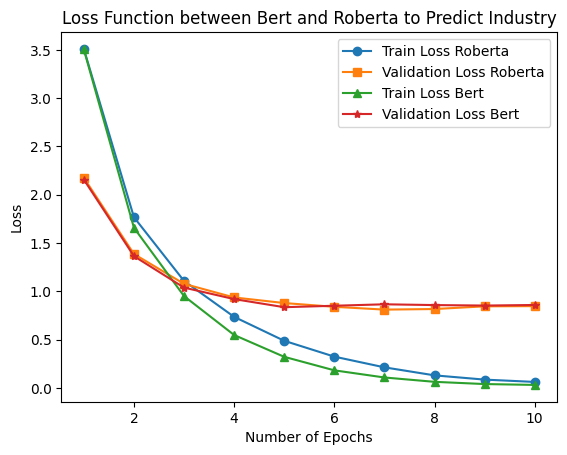

In [41]:
import matplotlib.pyplot as plt


x = [1, 2, 3, 4, 5,6,7,8,9,10]
plt.plot(x, train_losses_roberta, label='Train Loss Roberta', marker='o')
plt.plot(x, valid_losses_roberta, label='Validation Loss Roberta', marker='s')
plt.plot(x, train_losses_bert, label='Train Loss Bert', marker='^')
plt.plot(x, valid_losses_bert, label='Validation Loss Bert', marker='*')
plt.xlabel('Number of Epochs')
plt.ylabel('Loss')
plt.title('Loss Function between Bert and Roberta to Predict Industry')
plt.legend()
plt.savefig('loss_IG.jpg', format='jpg', dpi=300)
plt.show()

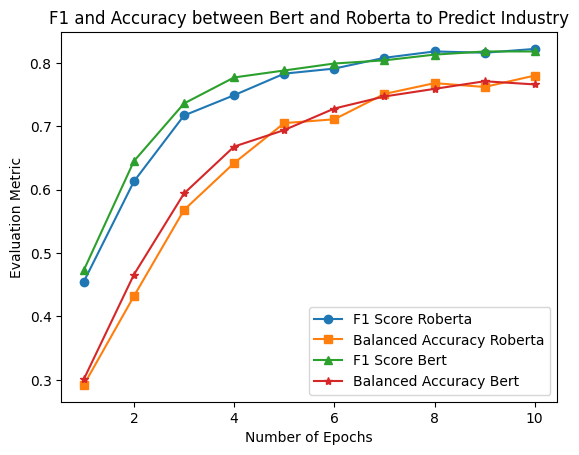

In [42]:
import matplotlib.pyplot as plt


x = [1, 2, 3, 4, 5,6,7,8,9,10]
plt.plot(x, f1_scores_roberta, label='F1 Score Roberta', marker='o')
plt.plot(x, balanced_accuracies_roberta, label='Balanced Accuracy Roberta', marker='s')
plt.plot(x, f1_scores_bert, label='F1 Score Bert', marker='^')
plt.plot(x, balanced_accuracies_bert, label='Balanced Accuracy Bert', marker='*')
plt.xlabel('Number of Epochs')
plt.ylabel('Evaluation Metric')
plt.title('F1 and Accuracy between Bert and Roberta to Predict Industry')
plt.legend()
plt.savefig('evaluation_IG.jpg', format='jpg', dpi=300)
plt.show()

# Prediction of TM dataset based on NICE classes

In [31]:
Sample_TM_800_Unique_Files = pd.read_excel('Sample_TM_800_Unique_Files.xlsx')

In [32]:
Sample_TM_800_Unique_Files = Sample_TM_800_Unique_Files.dropna(subset=['TEXT']).reset_index(drop=True)

In [33]:
texts = Sample_TM_800_Unique_Files['TEXT'].tolist()

In [34]:
#tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
test_encodings = tokenizer(texts, truncation=True, padding=True, return_tensors='pt')

In [35]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
test_encodings = {key: val.to(device) for key, val in test_encodings.items()}

In [37]:
test_dataset = TensorDataset(test_encodings['input_ids'], 
                              #test_encodings['token_type_ids'], 
                              test_encodings['attention_mask']
                              )

In [38]:
batch_size = 16

# Create DataLoader
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [40]:
model.eval()
test_preds = []

# Iterate through the test DataLoader
with torch.no_grad():
    for batch in test_dataloader:
        input_ids,  attention_mask = batch  # adjust based on your input features

        # Make predictions using the model
        outputs = model(input_ids,  attention_mask=attention_mask)
        logits = outputs.logits

        # Assuming a classification task, get predicted class labels
        preds = torch.argmax(logits, dim=1).cpu().numpy()
        test_preds.extend(preds)

In [41]:
Sample_TM_800_Unique_Files['industry_group_label_pred'] = test_preds

In [42]:
def map_values(value):
    return mapping_IG_reverse.get(value, value)  # Use get to handle cases where the key is not in the dictionary

# Apply the function to create the new column
Sample_TM_800_Unique_Files['industry_group_pred'] = Sample_TM_800_Unique_Files['industry_group_label_pred'].apply(map_values)

In [322]:
Sample_TM_800_Unique_Files_BERT_PREDICT = pd.read_csv('Sample_TM_800_Unique_Files_BERT_PREDICT.csv')

In [325]:
Sample_TM_800_Unique_Files['industry_group_bert_pred'] = list(Sample_TM_800_Unique_Files_BERT_PREDICT['industry_group_pred'])

In [327]:
Sample_TM_800_Unique_Files.rename(columns={'industry_group_pred': 'industry_group_roberta_pred'}, inplace=True)

In [330]:
Sample_TM_800_Unique_Files_select = Sample_TM_800_Unique_Files[['UNIQUE_FILE_NUMBER',
 'NICE_CLASS_CODE',
 'LEGAL_NAME_UPD',
 
 'NAICS Marianne',
 'NAICS Sebastien',
 
 'TEXT',
 
 'industry_group_roberta_pred',
 'industry_group_bert_pred']]

In [332]:
Sample_TM_800_Unique_Files_select.to_csv('Sample_TM_800_Unique_Files_BERT_ROBERTA_PREDICT.csv', index=False)

In [483]:
Sample_TM_800_Unique_Files_select[20:30]

,UNIQUE_FILE_NUMBER,NICE_CLASS_CODE,LEGAL_NAME_UPD,NAICS Marianne,NAICS Sebastien,TEXT,industry_group_roberta_pred,industry_group_bert_pred
20,2151540_0,25,12783185 canada inc,414110.0,458114,"Clothing, namely casual clothing, t-shirts, sh...",3152,3152
21,2151540_0,28,12783185 canada inc,414460.0,459120,Action skill games; action figures; board game...,3399,3399
22,2170765_0,9,12783185 canada inc,541514.0,518210,Downloadable computer software for accessing d...,3346,5182
23,2170765_0,41,12783185 canada inc,459120.0,449212,Organization of e-sports competitions; enterta...,5121,5162
24,2170765_0,25,12783185 canada inc,414110.0,458114,"Clothing, namely casual clothing, t-shirts, sh...",3152,3152
25,2170765_0,28,12783185 canada inc,414460.0,459120,Action skill games; action figures; board game...,3399,3399
26,2130533_0,42,camber aviation management ltd,541330.0,541330,aeronautical engineering; technical research i...,5417,5417
27,2130713_0,36,emx royalty corporation,213119.0,213119,"Investing in and acquiring mining companies, o...",5222,5239
28,2130713_0,37,emx royalty corporation,213119.0,213119,Mine development services; mineral extraction ...,2131,2131
29,2130713_0,42,emx royalty corporation,213119.0,213119,Mineral exploration.,2131,2131


In [ ]:
Roberta = 11,12,18,19,20,22,26,30*,34*,37,162,87**,85**,99**,104**,106,
bert = 15,19,23,27**

In [488]:
Sample_TM_800_Unique_Files_select['TEXT'][24]

'Clothing, namely casual clothing, t-shirts, shirts, sweatshirts, hoodies, hats, dresses, skirts, pants, jackets, scarves, toques, coats, undergarments, belts, tank tops, socks and gloves'

In [479]:
IG = 8133
for i in range(len(NAICS_2022[NAICS_2022.INDUSTRY_GROUP == IG]['Class title'].reset_index(drop = True))):
    print(NAICS_2022[NAICS_2022.INDUSTRY_GROUP == IG]['Class title'].reset_index(drop = True)[i])

Social advocacy organizations


In [480]:
for i in range(len(NAICS_2022[NAICS_2022.INDUSTRY_GROUP == IG]['Class definition'].reset_index(drop = True))):
    print(NAICS_2022[NAICS_2022.INDUSTRY_GROUP == IG]['Class definition'].reset_index(drop = True)[i])

This Canadian industry comprises establishments primarily engaged in promoting a particular social or political cause intended to benefit a broad or specific constituency.


In [481]:
for i in range(len(NAICS_2022[NAICS_2022.INDUSTRY_GROUP == IG]['EXAMPLE_SPLIT'].reset_index(drop = True))):
    print(NAICS_2022[NAICS_2022.INDUSTRY_GROUP == IG]['EXAMPLE_SPLIT'].reset_index(drop = True)[i])

['accident prevention association', ' advocacy groups', ' animal rights organizations', ' antipoverty advocacy organizations', ' associations for retired persons, advocacy', ' aviation club, advocacy', ' civil liberties groups', ' community action advocacy groups', ' conservation advocacy groups', ' drug abuse prevention advocacy organizations', ' drunk driving prevention advocacy organizations', ' environmental advocacy groups', ' firearms advocacy organizations', ' gun control organizations', ' human rights advocacy organizations', ' humane society (advocacy group)', ' intellectually and developmentally disabled advocacy groups', ' natural resource preservation organizations', ' neighbourhood development advocacy groups', ' organizations for persons with developmental disabilities', ' peace advocacy groups', ' public interest groups (e.g., environment, conservation, human rights, wildlife)', ' public safety advocacy groups', ' public safety promotion association', ' services to promo